In [1]:
'''
Nicole Osayande
Bzdok Lab MILA
'''
import os
import aesara
import scipy as sp
import arviz as az
import numpy as np
import pymc3 as pm
import pandas as pd
import xarray as xr
import seaborn as sns
from theano import shared
import arviz.labels as azl
from scipy.stats import zscore
from theano import tensor as tt
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# Data Preprocessing

In [2]:
#import dataset
#investigating marital status and crystallized cognition
data = pd.read_csv('/Users/nicoleosa/Documents/ABCD_data/abcd_nda3_manuscript.csv', usecols=['nihtbx_cryst_uncorrected','married_or_livingtogether','abcd_site','site_id_l','race_ethnicity'], index_col=False)

In [3]:
#change categorical variable to numerical
data['married_or_livingtogether'].replace(['no','yes'],
                        [0,1], inplace=True)

In [4]:
data['nihtbx_cryst_uncorrected_log']= np.log(data['nihtbx_cryst_uncorrected']) #natural logarithm to fix skew-tailed data
col='nihtbx_cryst_uncorrected_log'
data['nihtbx_cryst_uncorrected_zscore'] = (data[col] - data[col].mean())/data[col].std(ddof=0) #standardization

In [5]:
# label encodings for multilevel strata
race_idxs, race = pd.factorize(data.race_ethnicity)
data['race_enc'] = race_idxs

state_idxs, state = pd.factorize(data.site_id_l)
data['state_enc'] = state_idxs

In [6]:
#get input variables for Theano shared objects (allows data to be swapped for poststratification)
abcd_race = data.race_enc.values
abcd_state = data.state_enc.values
tp = data.married_or_livingtogether.values
target_values = data.nihtbx_cryst_uncorrected_zscore.values

In [7]:
#initialize shared objects
abcd_race_ = shared(abcd_race)
abcd_state_ = shared(abcd_state)
tp_ = shared(tp)

# Run Model

In [8]:
#varying intercepts and varying slopes: 
#predicting crystallized cognition scores from parental marital status 

RANDOM_SEED = 8924
np.random.seed(286)

coords = {"abcd_race": np.arange(len(race)),"abcd_state": np.arange(len(state))}


with pm.Model(coords=coords) as varying_intercept_slope:
    
    # Hyperparameters
    a = pm.Normal("a", mu=0.0, sigma=5.0)
    sigma_a = pm.Exponential("sigma_a", 1.0)
    b = pm.Normal("b", mu=0.0, sigma=1.0)
    sigma_b = pm.Exponential("sigma_b", 0.5) 
   
    # Varying intercepts
    a_state = pm.Normal("a_state", mu=0.0, sigma=1.0, dims ='abcd_state')

    # Varying slopes
    b_race = pm.Normal("b_race", mu=0.0, sigma=1.0, dims ='abcd_race')
    

    # Expected value per state, theta
    # Non-centered reparameterization 
    # yhat = varying state-intercept + varying race-slope*SDV
    theta = (a + a_state[abcd_state_] * sigma_a) + (b + b_race[abcd_race_] * sigma_b) * tp_
    
    # Model error:
    sigma = pm.Exponential("sigma", 1.0)

    likelihood = pm.Normal("likelihood", theta, sigma=sigma, observed=target_values)
    
with varying_intercept_slope:
    varying_intercept_slope_idata = pm.sample(2000,
        tune=3000, init="adapt_diag", target_accept=0.99, random_seed=RANDOM_SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_race, a_state, sigma_b, b, sigma_a, a]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 935 seconds.
The number of effective samples is smaller than 25% for some parameters.


# Model Statistics

Text(0.5, 1.0, 'marital status model of crystallized cognition')

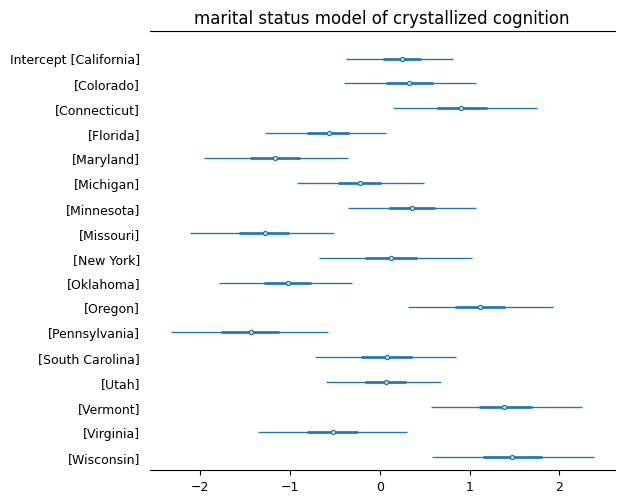

In [9]:
coords = {"abcd_state": [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]}
var_names = ["a_state"]
# Define the var_name_map and coord_map for custom labels
var_name_map = {"a_state": "Intercept "}
coord_map = {"abcd_state": { 0:'California', 1:'Colorado', 2:'Connecticut', 3:'Florida', 4:'Maryland',
       5:'Michigan', 6:'Minnesota', 7:'Missouri', 8:'New York', 9:'Oklahoma', 10:'Oregon',
       11:'Pennsylvania', 12:'South Carolina', 13:'Utah', 14:'Vermont', 15:'Virginia',
       16:'Wisconsin'}}

# Create the MapLabeller object
labeller = azl.MapLabeller(var_name_map=var_name_map, coord_map=coord_map)

axes= az.plot_forest(varying_intercept_slope_idata, var_names=var_names,coords=coords,labeller=labeller,combined=True, textsize=9);
fig = axes.ravel()[0].figure
plt.title("marital status model of crystallized cognition")

#fig.savefig('forest_plot_state_intercept_marry_crystallized_cognition_results_f3.svg',transparent=True,dpi=600,format='svg')

/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_43398/1786051202.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


Text(0.5, 1.0, 'marital status slope effects of crystallized cognition')

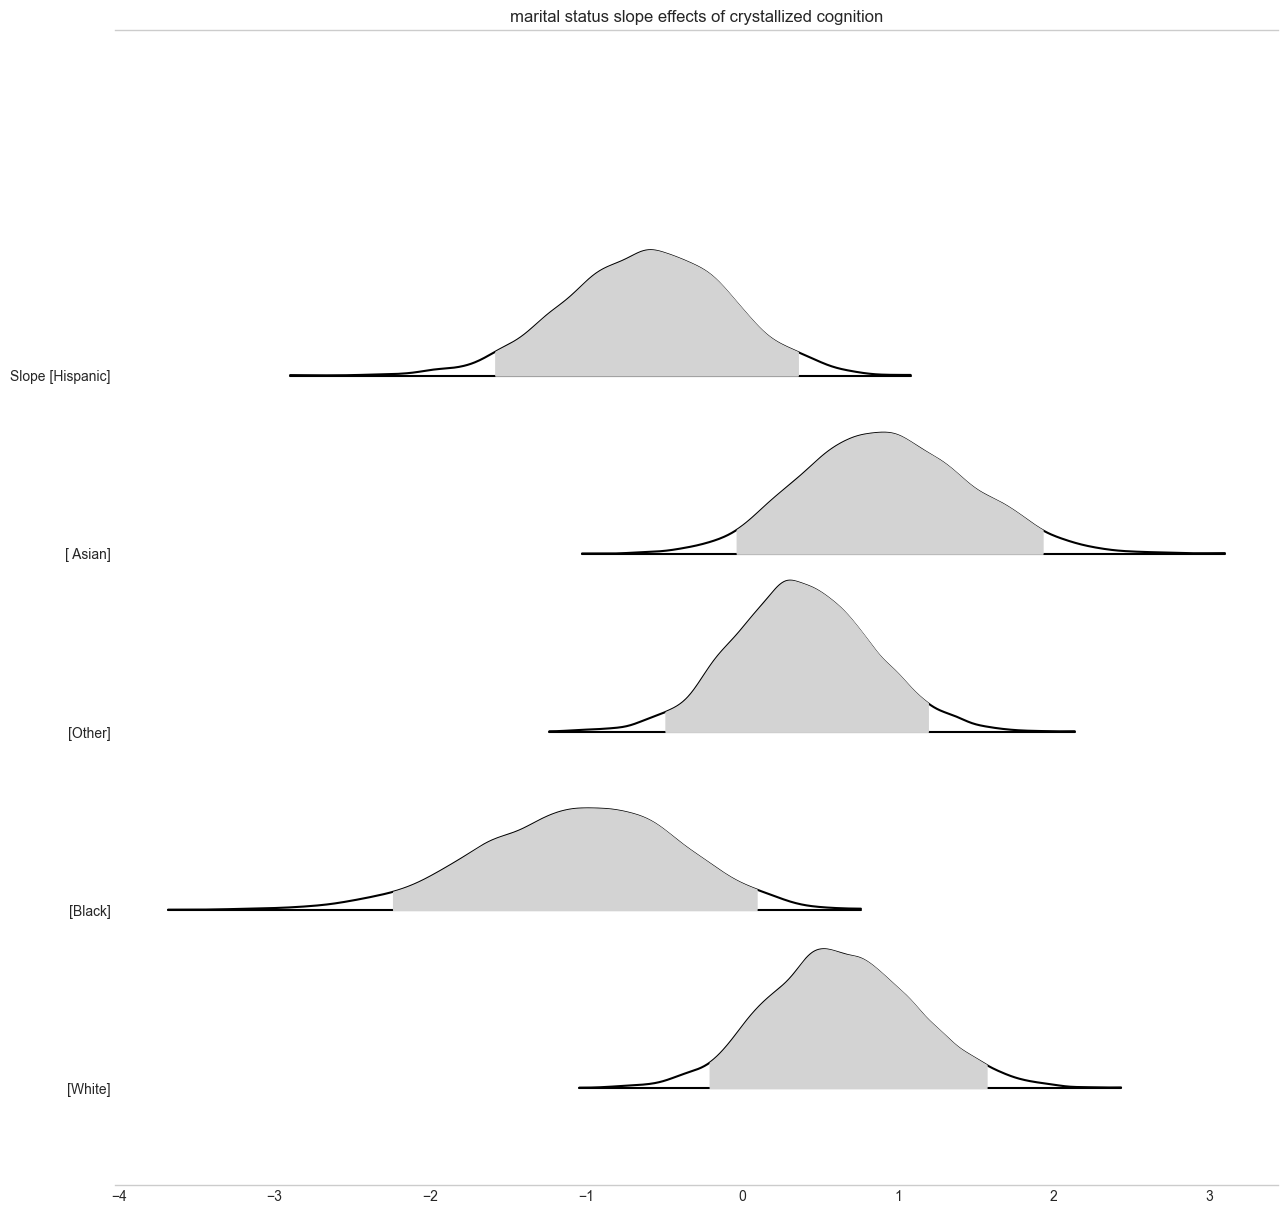

In [10]:
plt.style.use('seaborn-whitegrid')
coords = {"abcd_race": [0,1,2,3,4]}
var_names = ["b_race"]
# Define the var_name_map and coord_map for custom labels
var_name_map = {"b_race": "Slope "}
coord_map = {"abcd_race": { 0:"Hispanic", 1: " Asian", 2:"Other", 3:"Black", 4:"White"}}

# Create the MapLabeller object
labeller = azl.MapLabeller(var_name_map=var_name_map, coord_map=coord_map)

axes = az.plot_forest(varying_intercept_slope_idata,
                           kind='ridgeplot',var_names=var_names,coords=coords,labeller=labeller,
                           combined=True,
                           ridgeplot_truncate=False,
                           ridgeplot_overlap=0.7,
                           colors='lightgrey',
                           figsize=(15, 15))
fig = axes.ravel()[0].figure
plt.title("marital status slope effects of crystallized cognition")
#fig.savefig('forest_ridge_plot_race_slope_marry_crystallized_cognition_results_f3.svg',transparent=True,dpi=600,format='svg')

In [11]:
#Posterior predictive check
with varying_intercept_slope:
    ppc = pm.sample_posterior_predictive(varying_intercept_slope_idata, var_names=["likelihood","a_state","b_race"], random_seed=RANDOM_SEED)
    

In [12]:
# Bayesian R2 score 
az.r2_score(target_values, ppc['likelihood'])

r2        0.366894
r2_std    0.003496
dtype: float64

# Visualizing predictions

plots at the bottom

In [13]:
#create ppc dataframe 
PP_COL = ['pp_cog_{}'.format(i) for i in range(ppc['likelihood'].shape[0])]
ppc_df = pd.DataFrame(ppc['likelihood'].T, columns=PP_COL)

In [14]:
# get race, state and parental marital status columns for ppc dataframe, reset index for merging dataframes
abcd_race_df = pd.DataFrame(data['race_ethnicity'],columns =['race_ethnicity']).reset_index(drop=True)
abcd_state_df = pd.DataFrame(data['site_id_l'],columns =['site_id_l']).reset_index(drop=True)
abcd_tp_df = pd.DataFrame(data['married_or_livingtogether'],columns =['married_or_livingtogether']).reset_index(drop=True)


In [15]:
ppc_df = pd.merge(abcd_race_df,ppc_df,left_index=True, right_index=True)
ppc_df = pd.merge(abcd_state_df,ppc_df,left_index=True, right_index=True)
ppc_df = pd.merge(abcd_tp_df,ppc_df,left_index=True, right_index=True)


In [16]:
ppc_tp_race_mean = (ppc_df.groupby(['married_or_livingtogether','race_ethnicity']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_tp_race_mean

pp_cog_0  pp_cog_1  pp_cog_2  \
married_or_livingtogether race_ethnicity                                 
0                         Asian          -0.350557 -0.280517 -0.803299   
                          Black          -0.396750 -0.426954 -0.462967   
                          Hispanic       -0.391789 -0.369443 -0.485312   
                          Other          -0.417463 -0.421914 -0.427434   
                          White          -0.409761 -0.373060 -0.384263   
1                         Asian           0.379138  0.609713  0.530451   
                          Black          -0.380943 -0.508384 -0.445581   
                          Hispanic       -0.236621 -0.205294 -0.226509   
                          Other           0.213980  0.110182  0.187997   
                          White           0.332268  0.344758  0.317159   

                                          pp_cog_3  pp_cog_4  pp_cog_5  \
married_or_livingtogether race_ethnicity                                 
0                         Asian          -0.202534 -0.532828 -0.495841   
                          Black          -0.446798 -0.477465 -0.509902   
                          Hispanic       -0.387408 -0.371824 -0.436140   
                          Other          -0.430907 -0.341623 -0.494820   
                          White          -0.446123 -0.385226 -0.351941   
1                         Asian           0.373736  0.411192  0.415909   
                          Black          -0.526778 -0.494264 -0.478961   
                          Hispanic       -0.225110 -0.200221 -0.280609   
                          Other           0.167016  0.143843  0.141583   
                          White           0.357652  0.369059  0.309885   

                                          pp_cog_6  pp_cog_7  pp_cog_8  \
married_or_livingtogether race_ethnicity                                 
0                         Asian          -0.166413 -0.326389 -0.800549   
                          Black          -0.502577 -0.488527 -0.489594   
                          Hispanic       -0.334610 -0.445880 -0.375784   
                          Other          -0.446508 -0.531516 -0.502895   
                          White          -0.427550 -0.395977 -0.426613   
1                         Asian           0.512393  0.430093  0.536548   
                          Black          -0.451171 -0.471565 -0.537085   
                          Hispanic       -0.237120 -0.288201 -0.283223   
                          Other           0.209468  0.131501  0.282227   
                          White           0.353488  0.331329  0.311502   

                                          pp_cog_9  ...  pp_cog_7990  \
married_or_livingtogether race_ethnicity            ...                
0                         Asian          -0.094039  ...    -0.535611   
                          Black          -0.431846  ...    -0.468651   
                          Hispanic       -0.461511  ...    -0.395946   
                          Other          -0.462664  ...    -0.469131   
                          White          -0.442250  ...    -0.376084   
1                         Asian           0.371521  ...     0.243640   
                          Black          -0.517552  ...    -0.566007   
                          Hispanic       -0.162913  ...    -0.263517   
                          Other           0.111102  ...     0.207954   
                          White           0.313966  ...     0.341594   

                                          pp_cog_7991  pp_cog_7992  \
married_or_livingtogether race_ethnicity                             
0                         Asian             -0.241358    -0.221003   
                          Black             -0.524750    -0.471667   
                          Hispanic          -0.348743    -0.359294   
                          Other             -0.431989    -0.374608   
                          White             -0.402226    -0.437677   
1                   

In [17]:
#average predicted score across race groups separated by parental status
ppc_tp_race_mean_summ=ppc_tp_race_mean.mean(axis=1)
ppc_tp_race_mean_summ

married_or_livingtogether  race_ethnicity
0                          Asian            -0.386524
                           Black            -0.468357
                           Hispanic         -0.395988
                           Other            -0.433195
                           White            -0.398271
1                          Asian             0.477325
                           Black            -0.512497
                           Hispanic         -0.245806
                           Other             0.190019
                           White             0.329183
dtype: float64

In [18]:
ppc_race_mean = (ppc_df.groupby(['race_ethnicity']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_race_mean

,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,pp_cog_6,pp_cog_7,pp_cog_8,pp_cog_9,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
race_ethnicity,,,,,,,,,,,,,,,,,,,,,
Asian,0.311403,0.527075,0.406643,0.320243,0.323562,0.331274,0.449382,0.359871,0.412430,0.328304,...,0.171305,0.399733,0.379143,0.372446,0.542643,0.465543,0.420442,0.352694,0.386732,0.339681
Black,-0.390694,-0.458150,-0.456306,-0.477439,-0.483901,-0.498048,-0.482883,-0.482029,-0.507788,-0.464680,...,-0.505949,-0.532854,-0.523381,-0.491365,-0.520878,-0.512395,-0.541353,-0.493271,-0.423018,-0.520383
Hispanic,-0.283534,-0.254922,-0.304755,-0.274178,-0.252103,-0.327632,-0.266594,-0.335873,-0.311208,-0.253190,...,-0.303555,-0.240699,-0.274314,-0.271837,-0.252175,-0.271136,-0.370622,-0.242110,-0.284198,-0.248059
Other,0.037556,-0.038485,0.016046,-0.000043,0.008204,-0.036227,0.026189,-0.053745,0.062865,-0.049208,...,0.018777,0.000009,0.015769,0.023222,0.035269,-0.009517,0.044976,-0.046351,-0.016300,0.045153
White,0.220417,0.236556,0.211428,0.236493,0.255360,0.210123,0.235756,0.221697,0.200240,0.199976,...,0.233413,0.206838,0.203742,0.229654,0.219085,0.202663,0.197552,0.222773,0.235866,0.243964


In [19]:
ppc_race_mean_summ = ppc_race_mean.mean(axis=1)

In [20]:
ppc_tp_state_mean = (ppc_df.groupby(['married_or_livingtogether','site_id_l']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_tp_state_mean_summ = ppc_tp_state_mean.mean(axis=1)


In [21]:
ppc_state_mean = (ppc_df.groupby(['site_id_l']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_state_mean_summ = ppc_state_mean.mean(axis=1) #for the geomaps


In [22]:
ppc_tp_state_mean_summ_list=ppc_tp_state_mean_summ.to_numpy()
low_tp_state = ppc_tp_state_mean_summ_list[:17]
high_tp_state = ppc_tp_state_mean_summ_list[-17:]

In [23]:
mean_predictions_state = [low_tp_state,high_tp_state] 
  
# Create the pandas DataFrame 
mean_pred_state = pd.DataFrame(mean_predictions_state, columns=state) 
  
# print dataframe. 
mean_pred_state

,california,colorado,connecticut,florida,maryland,michigan,minnesota,missouri,newyork,oklahoma,oregon,pennsylvania,southcarolina,utah,vermont,virginia,wisconsin
0,-0.361704,-0.349175,-0.274464,-0.466005,-0.541084,-0.422520,-0.347205,-0.556861,-0.376967,-0.523257,-0.251210,-0.576881,-0.382770,-0.383492,-0.215798,-0.460034,-0.205248
1,0.062853,0.221094,0.261855,-0.106090,-0.042874,0.150433,0.292028,-0.010883,0.196608,-0.001143,0.358436,-0.189842,0.168065,0.259032,0.467707,0.080212,0.415506


In [24]:
ppc_tp_race_mean_summ_list=ppc_tp_race_mean_summ.to_numpy()
low_tp_race = ppc_tp_race_mean_summ_list[:5]
high_tp_race = ppc_tp_race_mean_summ_list[-5:]

In [25]:
# initialize list of lists 
mean_predictions_race = [low_tp_race,high_tp_race] 

mean_pred_race = pd.DataFrame(mean_predictions_race, columns=["Asian","Black","Hispanic","Other","White"]) 

mean_pred_race

,Asian,Black,Hispanic,Other,White
0,-0.386524,-0.468357,-0.395988,-0.433195,-0.398271
1,0.477325,-0.512497,-0.245806,0.190019,0.329183


# Poststratifcation Steps

In [26]:
#auxiliary data
census_data = pd.read_csv('/Users/nicoleosa/Documents/ABCD_data/census_poststrat_dataset.csv', usecols=['state','Single_Parent_Fam_score','County_population','race_ethnicity'], index_col=False)

In [27]:
val = census_data['Single_Parent_Fam_score'].median()
census_data.loc[census_data['Single_Parent_Fam_score'] < val, 'Single_Parent_Fam_score_bin'] = 1
census_data.loc[census_data['Single_Parent_Fam_score'] >= val, 'Single_Parent_Fam_score_bin'] = 0

In [28]:
census = (census_data.groupby(['state','race_ethnicity','Single_Parent_Fam_score_bin']).County_population.agg(['sum']).reset_index())
census = census.rename(columns={'sum': 'freq'})
census

,state,race_ethnicity,Single_Parent_Fam_score_bin,freq
0,california,Asian,0.0,1066853
1,california,Asian,1.0,768462
2,california,Black,0.0,786431
3,california,Black,1.0,3168044
4,california,Hispanic,0.0,2979380
...,...,...,...,...
139,wisconsin,Hispanic,1.0,44759
140,wisconsin,Other,0.0,168524
141,wisconsin,Other,1.0,14993
142,wisconsin,White,0.0,1875561


In [29]:
census['race_enc']=census['race_ethnicity']
census['race_enc'].replace(race,[0,1,2,3,4], inplace=True)
census['state_enc']=census['state']
census['state_enc'].replace(state,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16], inplace=True)
census.head()

,state,race_ethnicity,Single_Parent_Fam_score_bin,freq,race_enc,state_enc
0,california,Asian,0.0,1066853,1,0
1,california,Asian,1.0,768462,1,0
2,california,Black,0.0,786431,3,0
3,california,Black,1.0,3168044,3,0
4,california,Hispanic,0.0,2979380,0,0


In [30]:
#fix theano shared tensor type error
census=census.astype({'Single_Parent_Fam_score_bin':'uint8'})

In [31]:
#initialize poststrat vars
ps_abcd_race = census.race_enc.values
ps_abcd_state = census.state_enc.values
ps_tp = census.Single_Parent_Fam_score_bin.values

#swap the model input variables 
abcd_race_.set_value(ps_abcd_race)
abcd_state_.set_value(ps_abcd_state)
tp_.set_value(ps_tp)

In [32]:
#re-run posterior predictive check with auxiliary census SDI data
with varying_intercept_slope:
    ppc2 = pm.sample_posterior_predictive(varying_intercept_slope_idata,var_names=['likelihood','a_state','b_race'],random_seed=RANDOM_SEED)
    

In [33]:
#create ppc dataframe 
PP_COL2 = ['pp_cog_{}'.format(i) for i in range(ppc2['likelihood'].shape[0])]
ppc_df2 = pd.DataFrame(ppc2['likelihood'].T, columns=PP_COL2)
ppc_df2.shape


(144, 8000)

In [34]:
censust=census
censust

,state,race_ethnicity,Single_Parent_Fam_score_bin,freq,race_enc,state_enc
0,california,Asian,0,1066853,1,0
1,california,Asian,1,768462,1,0
2,california,Black,0,786431,3,0
3,california,Black,1,3168044,3,0
4,california,Hispanic,0,2979380,0,0
...,...,...,...,...,...,...
139,wisconsin,Hispanic,1,44759,0,16
140,wisconsin,Other,0,168524,2,16
141,wisconsin,Other,1,14993,2,16
142,wisconsin,White,0,1875561,4,16


In [35]:
# get race, state, and parental marital status  columns for ppc dataframe, reset index for merging dataframes
abcd_race_df2 = pd.DataFrame(censust['race_ethnicity'],columns =['race_ethnicity']).reset_index(drop=True)
abcd_state_df2 = pd.DataFrame(censust['state'],columns =['state']).reset_index(drop=True)
abcd_tp_df2 = pd.DataFrame(censust['Single_Parent_Fam_score_bin'],columns =['Single_Parent_Fam_score_bin']).reset_index(drop=True)


In [36]:
ppc_df2 = pd.merge(censust['freq'],ppc_df2,left_index=True, right_index=True)
ppc_df2 = pd.merge(abcd_tp_df2,ppc_df2,left_index=True, right_index=True)
ppc_df2 = pd.merge(abcd_race_df2,ppc_df2,left_index=True, right_index=True)
ppc_df2 = pd.merge(abcd_state_df2,ppc_df2,left_index=True, right_index=True)
ppc_df2

,state,race_ethnicity,Single_Parent_Fam_score_bin,freq,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
0,california,Asian,0,1066853,-0.047812,-0.150003,0.211303,-0.516259,-0.355881,-2.146152,...,-0.599643,-1.032226,-0.932463,-0.098149,-1.008439,0.675038,-0.000329,-0.431279,0.530232,-1.152155
1,california,Asian,1,768462,1.346084,-1.219733,2.074487,0.900299,-1.060188,1.460905,...,0.197584,1.761069,1.206622,0.808357,1.356334,0.665521,1.290730,0.955027,0.459654,-0.213429
2,california,Black,0,786431,0.355706,-0.335389,-0.574976,-1.781523,0.736947,1.739991,...,-0.175629,-0.949336,-0.733709,-0.359730,0.232340,-0.584976,0.330820,-0.432560,-0.716505,-0.930883
3,california,Black,1,3168044,-1.741360,-2.081972,-1.999668,-0.558087,-0.504894,0.138955,...,0.066608,-1.218187,-0.036246,-1.498873,-1.927097,0.028206,-0.791758,-2.381157,-0.483586,0.644109
4,california,Hispanic,0,2979380,-1.740764,0.508008,-0.668459,-0.315468,-0.969106,-2.034687,...,0.031479,-2.013782,-0.576232,0.793833,-0.758681,0.372033,-0.459227,-1.161237,0.882014,-1.038138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,wisconsin,Hispanic,1,44759,-0.626408,0.055101,-0.042063,-0.688443,0.903614,0.039787,...,-0.257591,-0.225087,-1.345133,-1.991315,-0.521164,-0.709295,-0.024294,-0.655843,0.426560,1.059928
140,wisconsin,Other,0,168524,-0.353047,-0.923232,0.671020,0.078348,-0.157224,0.355832,...,-0.268761,-0.908043,1.668166,-1.278583,0.282494,-0.034198,0.783473,0.580774,-1.082133,1.917795
141,wisconsin,Other,1,14993,-0.241902,-0.605584,-0.145580,2.376921,-1.305976,1.105016,...,-0.328548,0.362290,-1.723381,0.205518,0.276262,1.358954,0.946894,0.137005,0.847757,1.323400
142,wisconsin,White,0,1875561,0.371762,0.825509,-1.465995,0.220775,-1.489762,-0.639676,...,-0.155144,0.695594,-1.010717,-0.361205,0.383785,0.201249,-1.437283,1.145427,1.185744,-0.734807


In [37]:
#data-weighted for each category
ppc_poststrat_df = ppc_df2.groupby(['state','race_ethnicity','Single_Parent_Fam_score_bin']).apply(lambda df: (df[PP_COL2]*df.freq.sum(axis=0)))
ppc_poststrat_df

pp_cog_0  \
state      race_ethnicity Single_Parent_Fam_score_bin                     
california Asian          0                           0   -5.100832e+04   
                          1                           1    1.034415e+06   
           Black          0                           2    2.797380e+05   
                          1                           3   -5.516705e+06   
           Hispanic       0                           4   -5.186399e+06   
...                                                                 ...   
wisconsin  Hispanic       1                           139 -2.803740e+04   
           Other          0                           140 -5.949687e+04   
                          1                           141 -3.626836e+03   
           White          0                           142  6.972617e+05   
                          1                           143  6.234668e+05   

                                                               pp_cog_1  \
state      race_ethnicity Single_Parent_Fam_score_bin                     
california Asian          0                           0   -1.600306e+05   
                          1                           1   -9.373184e+05   
           Black          0                           2   -2.637605e+05   
                          1                           3   -6.595778e+06   
           Hispanic       0                           4    1.513548e+06   
...                                                                 ...   
wisconsin  Hispanic       1                           139  2.466284e+03   
           Other          0                           140 -1.555868e+05   
                          1                           141 -9.079524e+03   
           White          0                           142  1.548292e+06   
                          1                           143  2.605595e+06   

                                                               pp_cog_2  \
state      race_ethnicity Single_Parent_Fam_score_bin                     
california Asian          0                           0    2.254296e+05   
                          1                           1    1.594165e+06   
           Black          0                           2   -4.521791e+05   
                          1                           3   -6.335038e+06   
           Hispanic       0                           4   -1.991592e+06   
...                                                                 ...   
wisconsin  Hispanic       1                           139 -1.882704e+03   
           Other          0                           140  1.130830e+05   
                          1                           141 -2.182684e+03   
           White          0                           142 -2.749563e+06   
                          1                           143  2.746063e+06   

                                                               pp_cog_3  \
state      race_ethnicity Single_Parent_Fam_score_bin                     
california Asian          0                           0   -5.507730e+05   
                          1                           1    6.918458e+05   
           Black          0                           2   -1.401045e+06   
                          1                           3   -1.768044e+06   
           Hispanic       0                           4   -9.398984e+05   
...                                                                 ...   
wisconsin  Hispanic       1                           139 -3.081401e+04   
           Other          0                           140  1.320349e+04   
                          1                           141  3.563717e+04   
           White          0                           142  4.140764e+05   
                          1                           143  4.138946e+05   

                                                               pp_cog_4  \
state      race_ethnicity Single_Parent_Fam_score_bin                     
californi

In [38]:
#re-format groupby to remove multi-index
ppc_poststrat_df = ppc_poststrat_df.to_numpy()
ppc_poststrat_df = pd.DataFrame(ppc_poststrat_df, columns=PP_COL2)
ppc_poststrat_df

,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,pp_cog_6,pp_cog_7,pp_cog_8,pp_cog_9,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
0,-5.100832e+04,-1.600306e+05,2.254296e+05,-5.507730e+05,-3.796723e+05,-2.289629e+06,-8.466416e+05,2.178977e+05,8.961864e+05,2.105987e+06,...,-6.397308e+05,-1.101233e+06,-9.948004e+05,-1.047105e+05,-1.075856e+06,7.201659e+05,-3.504759e+02,-4.601112e+05,5.656798e+05,-1.229180e+06
1,1.034415e+06,-9.373184e+05,1.594165e+06,6.918458e+05,-8.147145e+05,1.122650e+06,1.272475e+06,-1.432121e+05,7.729083e+05,1.584508e+06,...,1.518360e+05,1.353315e+06,9.272431e+05,6.211920e+05,1.042291e+06,5.114279e+05,9.918773e+05,7.339021e+05,3.532269e+05,-1.640124e+05
2,2.797380e+05,-2.637605e+05,-4.521791e+05,-1.401045e+06,5.795577e+05,1.368382e+06,-1.221337e+06,-5.971310e+05,-1.121796e+06,-5.543408e+05,...,-1.381205e+05,-7.465870e+05,-5.770118e+05,-2.829026e+05,1.827197e+05,-4.600431e+05,2.601671e+05,-3.401785e+05,-5.634818e+05,-7.320753e+05
3,-5.516705e+06,-6.595778e+06,-6.335038e+06,-1.768044e+06,-1.599528e+06,4.402168e+05,-7.445681e+05,4.466483e+06,1.483760e+06,4.980674e+06,...,2.110163e+05,-3.859270e+06,-1.148297e+05,-4.748495e+06,-6.105128e+06,8.935874e+04,-2.508323e+06,-7.543611e+06,-1.532022e+06,2.040566e+06
4,-5.186399e+06,1.513548e+06,-1.991592e+06,-9.398984e+05,-2.887336e+06,-6.062106e+06,1.826713e+06,-6.840724e+05,1.499311e+06,-4.460735e+06,...,9.378694e+04,-5.999823e+06,-1.716815e+06,2.365129e+06,-2.260400e+06,1.108428e+06,-1.368211e+06,-3.459767e+06,2.627854e+06,-3.093006e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,-2.803740e+04,2.466284e+03,-1.882704e+03,-3.081401e+04,4.044484e+04,1.780829e+03,4.528784e+04,1.999955e+04,7.571898e+03,1.891355e+04,...,-1.152952e+04,-1.007468e+04,-6.020681e+04,-8.912928e+04,-2.332678e+04,-3.174731e+04,-1.087359e+03,-2.935488e+04,1.909241e+04,4.744130e+04
140,-5.949687e+04,-1.555868e+05,1.130830e+05,1.320349e+04,-2.649606e+04,5.996616e+04,-1.605622e+05,-2.126822e+05,-3.394727e+05,-4.596612e+05,...,-4.529276e+04,-1.530271e+05,2.811261e+05,-2.154719e+05,4.760700e+04,-5.763134e+03,1.320339e+05,9.787441e+04,-1.823654e+05,3.231945e+05
141,-3.626836e+03,-9.079524e+03,-2.182684e+03,3.563717e+04,-1.958050e+04,1.656750e+04,1.477640e+04,1.518583e+04,1.115593e+04,1.313805e+04,...,-4.925921e+03,5.431810e+03,-2.583865e+04,3.081330e+03,4.142001e+03,2.037480e+04,1.419677e+04,2.054117e+03,1.271043e+04,1.984174e+04
142,6.972617e+05,1.548292e+06,-2.749563e+06,4.140764e+05,-2.794139e+06,-1.199751e+06,-5.840464e+06,-2.848362e+05,-4.369063e+05,-1.835016e+05,...,-2.909821e+05,1.304630e+06,-1.895661e+06,-6.774611e+05,7.198128e+05,3.774549e+05,-2.695712e+06,2.148318e+06,2.223934e+06,-1.378175e+06


In [39]:
ppc_df2_sub = ppc_df2.iloc[:, : 4] #get the input var, race, state and freq columns, to perform another group by for the final posstratification step
ppc_df2_sub

,state,race_ethnicity,Single_Parent_Fam_score_bin,freq
0,california,Asian,0,1066853
1,california,Asian,1,768462
2,california,Black,0,786431
3,california,Black,1,3168044
4,california,Hispanic,0,2979380
...,...,...,...,...
139,wisconsin,Hispanic,1,44759
140,wisconsin,Other,0,168524
141,wisconsin,Other,1,14993
142,wisconsin,White,0,1875561


In [40]:
ppc_poststrat_df = pd.merge(ppc_df2_sub,ppc_poststrat_df,left_index=True, right_index=True) #merge the extracted colums with the dataframe from the first step of poststratification
ppc_poststrat_df

,state,race_ethnicity,Single_Parent_Fam_score_bin,freq,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
0,california,Asian,0,1066853,-5.100832e+04,-1.600306e+05,2.254296e+05,-5.507730e+05,-3.796723e+05,-2.289629e+06,...,-6.397308e+05,-1.101233e+06,-9.948004e+05,-1.047105e+05,-1.075856e+06,7.201659e+05,-3.504759e+02,-4.601112e+05,5.656798e+05,-1.229180e+06
1,california,Asian,1,768462,1.034415e+06,-9.373184e+05,1.594165e+06,6.918458e+05,-8.147145e+05,1.122650e+06,...,1.518360e+05,1.353315e+06,9.272431e+05,6.211920e+05,1.042291e+06,5.114279e+05,9.918773e+05,7.339021e+05,3.532269e+05,-1.640124e+05
2,california,Black,0,786431,2.797380e+05,-2.637605e+05,-4.521791e+05,-1.401045e+06,5.795577e+05,1.368382e+06,...,-1.381205e+05,-7.465870e+05,-5.770118e+05,-2.829026e+05,1.827197e+05,-4.600431e+05,2.601671e+05,-3.401785e+05,-5.634818e+05,-7.320753e+05
3,california,Black,1,3168044,-5.516705e+06,-6.595778e+06,-6.335038e+06,-1.768044e+06,-1.599528e+06,4.402168e+05,...,2.110163e+05,-3.859270e+06,-1.148297e+05,-4.748495e+06,-6.105128e+06,8.935874e+04,-2.508323e+06,-7.543611e+06,-1.532022e+06,2.040566e+06
4,california,Hispanic,0,2979380,-5.186399e+06,1.513548e+06,-1.991592e+06,-9.398984e+05,-2.887336e+06,-6.062106e+06,...,9.378694e+04,-5.999823e+06,-1.716815e+06,2.365129e+06,-2.260400e+06,1.108428e+06,-1.368211e+06,-3.459767e+06,2.627854e+06,-3.093006e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,wisconsin,Hispanic,1,44759,-2.803740e+04,2.466284e+03,-1.882704e+03,-3.081401e+04,4.044484e+04,1.780829e+03,...,-1.152952e+04,-1.007468e+04,-6.020681e+04,-8.912928e+04,-2.332678e+04,-3.174731e+04,-1.087359e+03,-2.935488e+04,1.909241e+04,4.744130e+04
140,wisconsin,Other,0,168524,-5.949687e+04,-1.555868e+05,1.130830e+05,1.320349e+04,-2.649606e+04,5.996616e+04,...,-4.529276e+04,-1.530271e+05,2.811261e+05,-2.154719e+05,4.760700e+04,-5.763134e+03,1.320339e+05,9.787441e+04,-1.823654e+05,3.231945e+05
141,wisconsin,Other,1,14993,-3.626836e+03,-9.079524e+03,-2.182684e+03,3.563717e+04,-1.958050e+04,1.656750e+04,...,-4.925921e+03,5.431810e+03,-2.583865e+04,3.081330e+03,4.142001e+03,2.037480e+04,1.419677e+04,2.054117e+03,1.271043e+04,1.984174e+04
142,wisconsin,White,0,1875561,6.972617e+05,1.548292e+06,-2.749563e+06,4.140764e+05,-2.794139e+06,-1.199751e+06,...,-2.909821e+05,1.304630e+06,-1.895661e+06,-6.774611e+05,7.198128e+05,3.774549e+05,-2.695712e+06,2.148318e+06,2.223934e+06,-1.378175e+06


In [41]:
#final step of poststratification - by race & marital status 
#data-weighted average
ppc_tp_race_poststrat = ppc_poststrat_df.groupby(['Single_Parent_Fam_score_bin','race_ethnicity']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_tp_race_poststrat


pp_cog_0  pp_cog_1  pp_cog_2  \
Single_Parent_Fam_score_bin race_ethnicity                                 
0                           Asian           0.274261  0.193665 -0.986496   
                            Black          -0.805928 -0.488749 -1.481367   
                            Hispanic       -0.665515 -0.293127 -0.442718   
                            Other          -0.497140 -1.094383 -0.777760   
                            White          -0.536570 -0.610702 -0.812388   
1                           Asian          -0.202913  0.535289  0.190557   
                            Black          -0.792715 -0.705790 -1.251915   
                            Hispanic       -1.052269  1.315196 -0.095679   
                            Other           0.612544  0.347773 -0.048361   
                            White           0.438896  0.306774 -0.161698   

                                            pp_cog_3  pp_cog_4  pp_cog_5  \
Single_Parent_Fam_score_bin race_ethnicity                                 
0                           Asian           0.143750 -0.746351  0.476218   
                            Black          -1.129918 -0.760033 -0.369875   
                            Hispanic        0.152221 -0.999121 -0.815007   
                            Other           0.125575  0.431716 -0.777785   
                            White          -0.434716 -0.582315 -0.586024   
1                           Asian           0.648388  0.230174  0.433670   
                            Black          -0.579768 -0.435327 -0.278284   
                            Hispanic       -0.944524  0.456853 -0.385167   
                            Other          -0.998432  0.928171  0.034765   
                            White           0.431898 -0.007746  0.656018   

                                            pp_cog_6  pp_cog_7  pp_cog_8  \
Single_Parent_Fam_score_bin race_ethnicity                                 
0                           Asian          -0.656193 -0.696380 -0.394484   
                            Black          -1.028770 -0.510404 -0.734277   
                            Hispanic       -0.213869  0.241373 -0.312457   
                            Other           0.622685 -0.982478 -0.611768   
                            White          -0.278726 -0.231902 -0.324708   
1                           Asian           0.201733  0.675597  0.195657   
                            Black          -0.482961 -0.329086 -0.007174   
                            Hispanic       -0.401421 -0.559878 -0.515280   
                            Other          -0.229662  0.262713  0.813767   
                            White           0.088047  0.179751  0.372072   

                                            pp_cog_9  ...  pp_cog_7990  \
Single_Parent_Fam_score_bin race_ethnicity            ...                
0                           Asian          -0.374926  ...     0.322130   
                            Black          -0.488061  ...    -0.556130   
                            Hispanic       -0.809051  ...    -0.455090   
                            Other          -0.803931  ...    -0.753860   
                            White          -0.661122  ...     0.203114   
1                           Asian           0.221078  ...    -0.159854   
                            Black           0.162509  ...     0.070468   
                            Hispanic       -0.941165  ...    -0.327862   
                            Other          -0.100058  ...     0.486816   
                            White           0.398115  ...    -0.033537   

                                            pp_cog_7991  pp_cog_7992  \
Single_Parent_Fam_score_bin race_ethnicity                             
0                           Asian             -0.571047    -0.927041   
                            Black             -0.065557    -0.186073   
                            Hispanic          -0.391366    -0.688969   
                            Other             -0.597873 

In [42]:
#summarize race & marital status poststrat results
ppc_tp_race_poststrat_summ = ppc_tp_race_poststrat.mean(axis=1)
ppc_tp_race_poststrat_summ

Single_Parent_Fam_score_bin  race_ethnicity
0                            Asian            -0.381457
                             Black            -0.448560
                             Hispanic         -0.418344
                             Other            -0.402202
                             White            -0.412357
1                            Asian             0.394113
                             Black            -0.468812
                             Hispanic         -0.239380
                             Other             0.150232
                             White             0.310101
dtype: float64

In [43]:
#final step postrat - by race
ppc_race_poststrat = ppc_poststrat_df.groupby(['race_ethnicity']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_race_poststrat_summ = ppc_race_poststrat.mean(axis=1)
ppc_race_poststrat_summ


race_ethnicity
Asian      -0.072172
Black      -0.458882
Hispanic   -0.349121
Other      -0.187675
White      -0.138594
dtype: float64

In [44]:
#for the lollipops
#final step poststrat - by state & marital status
ppc_tp_state_poststrat = ppc_poststrat_df.groupby(['Single_Parent_Fam_score_bin','state']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_tp_state_poststrat_summ = ppc_tp_state_poststrat.mean(axis=1)
ppc_tp_state_poststrat_summ

Single_Parent_Fam_score_bin  state        
0                            california      -0.368945
                             colorado        -0.347061
                             connecticut     -0.280607
                             florida         -0.466185
                             maryland        -0.532386
                             michigan        -0.433187
                             minnesota       -0.346920
                             missouri        -0.553567
                             newyork         -0.365823
                             oklahoma        -0.534102
                             oregon          -0.248961
                             pennsylvania    -0.580365
                             southcarolina   -0.384230
                             utah            -0.384864
                             vermont         -0.220105
                             virginia        -0.466559
                             wisconsin       -0.204026
1                     

In [45]:
#for the geomaps
#final step poststrat - by state
ppc_state_poststrat = ppc_poststrat_df.groupby(['state']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_state_poststrat_summ = ppc_state_poststrat.mean(axis=1)
ppc_state_poststrat_summ

state
california      -0.219117
colorado        -0.218511
connecticut     -0.051663
florida         -0.269766
maryland        -0.479938
michigan        -0.321413
minnesota       -0.188670
missouri        -0.410175
newyork         -0.128736
oklahoma        -0.427028
oregon          -0.047207
pennsylvania    -0.333440
southcarolina   -0.297979
utah             0.096989
vermont          0.182558
virginia        -0.150558
wisconsin        0.090082
dtype: float64

In [46]:
ppc_tp_state_poststrat_summ_list=ppc_tp_state_poststrat_summ.tolist()

In [47]:
#fill in missing value for connecticut
ppc_tp_state_poststrat_summ_list.insert(19,ppc_tp_state_mean_summ.iloc[19])

In [48]:
low_tp_state_poststrat = ppc_tp_state_poststrat_summ_list[:17]
high_tp_state_poststrat = ppc_tp_state_poststrat_summ_list[-17:]

In [49]:
ppc_tp_race_poststrat_summ_list=ppc_tp_race_poststrat_summ.tolist()

In [50]:
low_tp_race_poststrat = ppc_tp_race_poststrat_summ_list[:5]
high_tp_race_poststrat = ppc_tp_race_poststrat_summ_list[-5:]

In [51]:
mean_predictions_state_ps = [low_tp_state_poststrat,high_tp_state_poststrat] 
  
# Create the pandas DataFrame 
mean_pred_state_ps = pd.DataFrame(mean_predictions_state_ps, columns=state) 
  
# print dataframe. 
mean_pred_state_ps

,california,colorado,connecticut,florida,maryland,michigan,minnesota,missouri,newyork,oklahoma,oregon,pennsylvania,southcarolina,utah,vermont,virginia,wisconsin
0,-0.368945,-0.347061,-0.280607,-0.466185,-0.532386,-0.433187,-0.346920,-0.553567,-0.365823,-0.534102,-0.248961,-0.580365,-0.384230,-0.384864,-0.220105,-0.466559,-0.204026
1,-0.062439,0.261855,0.287773,0.069011,-0.422923,-0.111533,0.282266,0.061179,0.195782,0.073306,0.204010,0.008562,0.086045,0.150214,0.486387,0.086582,0.471456


In [52]:
# initialize list of lists 
mean_predictions_race_ps = [low_tp_race_poststrat,high_tp_race_poststrat] 
  
# Create the pandas DataFrame 
mean_pred_race_ps = pd.DataFrame(mean_predictions_race_ps, columns=["Asian","Black","Hispanic","Other","White"]) 
  
# print dataframe. 
mean_pred_race_ps

,Asian,Black,Hispanic,Other,White
0,-0.381457,-0.448560,-0.418344,-0.402202,-0.412357
1,0.394113,-0.468812,-0.239380,0.150232,0.310101


In [53]:
quantiles = [0.5]

# Calculate quantiles for each row (state)
quantiles_per_state = np.quantile(ppc_state_mean, quantiles, axis=1)
quantiles_per_state_ps = np.quantile(ppc_state_poststrat, quantiles, axis=1)

# Convert to list of lists
quantiles_state = quantiles_per_state.flatten().tolist()
quantiles_state_ps = quantiles_per_state_ps.flatten().tolist()

#quantiles_state,quantiles_state_ps

In [54]:
capitalized_states=['California',
 'Colorado',
 'Connecticut',
 'Florida',
 'Maryland',
 'Michigan',
 'Minnesota',
 'Missouri',
 'New York',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'South Carolina',
 'Utah',
 'Vermont',
 'Virginia',
 'Wisconsin']

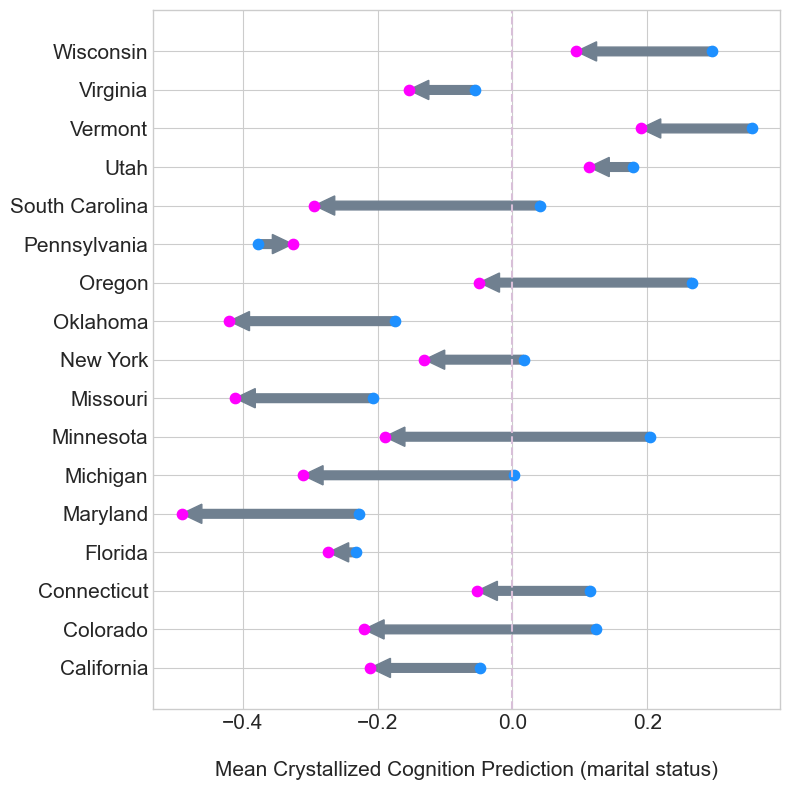

In [55]:
states = capitalized_states
quartiles_before_ps = quantiles_state   # mean prediction before poststratification
quartiles_after_ps = quantiles_state_ps  # mean prediction after poststratification

# Plotting
plt.figure(figsize=(8, 8))

# Plot arrows indicating change from before to after poststratification
for i in range(len(states)):
    plt.arrow(quartiles_before_ps[i], i, quartiles_after_ps[i] - quartiles_before_ps[i], 0, color='slategrey', width=0.225, head_width=0.5, head_length=0.03, length_includes_head=True)

# Plot second quartiles before poststratification
for i, state in enumerate(states):
    plt.scatter(quartiles_before_ps[i], i, marker='o', color='dodgerblue', label='Before PS' if i == 0 else "",s=55)  # Dot for second quartile

# Plot second quartiles after poststratification
for i, state in enumerate(states):
    plt.scatter(quartiles_after_ps[i], i, marker='o', color='fuchsia', label='After PS' if i == 0 else "",s=55)  # Dot for second quartile

# Add vertical dashed line at x = 0
plt.axvline(x=0, color='thistle', linestyle='--')

plt.yticks(range(len(states)), states,size=15)
plt.xticks(size=15)
plt.xlabel('Mean Crystallized Cognition Prediction (marital status)',size=15,labelpad=20)
#plt.title('Mean Predictions of Crystallized Cognition based on Marital Status Before and After Poststratification')
plt.grid(True)
#plt.legend()
#plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.tight_layout()
#plt.savefig('arrow_plot_marry_crystallized_ps_state_cognition_results_f4.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()

In [56]:
quantiles_per_race = np.quantile(ppc_race_mean, quantiles, axis=1)
quantiles_per_race_ps = np.quantile(ppc_race_poststrat, quantiles, axis=1)

# Convert to list of lists
quantiles_race = quantiles_per_race.flatten().tolist()
quantiles_race_ps = quantiles_per_race_ps.flatten().tolist()

#quantiles_race,quantiles_race_ps

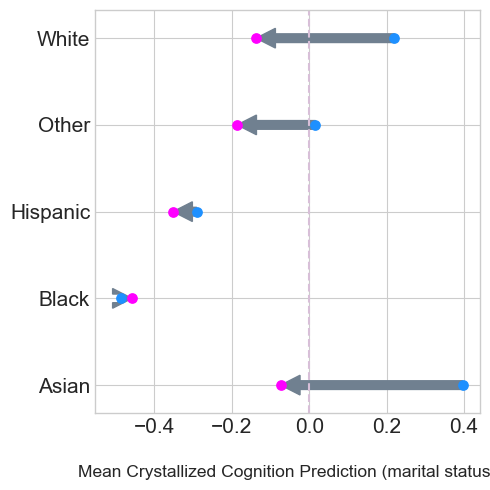

In [57]:
races = ['Asian','Black','Hispanic','Other','White']
quartiles_before_ps_r = quantiles_race   # mean prediction before poststratification
quartiles_after_ps_r = quantiles_race_ps  # mean prediction after poststratification

# Plotting
plt.figure(figsize=(5, 5))

# Plot arrows indicating change from before to after poststratification
for i in range(len(races)):
    plt.arrow(quartiles_before_ps_r[i], i, quartiles_after_ps_r[i] - quartiles_before_ps_r[i], 0, color='slategrey', width=0.10, head_width=0.227, head_length=0.05, length_includes_head=True)

# Plot second quartiles before poststratification
for i, race in enumerate(races):
    plt.scatter(quartiles_before_ps_r[i], i, marker='o', color='dodgerblue', label='Before PS' if i == 0 else "",s=45)  # Dot for second quartile

# Plot second quartiles after poststratification
for i, race in enumerate(races):
    plt.scatter(quartiles_after_ps_r[i], i, marker='o', color='fuchsia', label='After PS' if i == 0 else "",s=45)  # Dot for second quartile

# Add vertical dashed line at x = 0
plt.axvline(x=0, color='thistle', linestyle='--')

plt.yticks(range(len(races)), races,size=15)
plt.xticks(size=15)
plt.xlabel('Mean Crystallized Cognition Prediction (marital status)',size=12.5,labelpad=20)
#plt.title('Mean Predictions of Crystallized Cognition based on Marital Status Before and After Poststratification')
plt.grid(True)
#plt.legend()
#plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.tight_layout()
#plt.savefig('arrow_plot_marry_crystallized_ps_race_cognition_results_f4.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()

/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_43398/3121183004.py:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(state_values, [state_name, state_name], 'k-',color='dodgerblue', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_43398/3121183004.py:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(state_values2, [state_name2, state_name2], 'k-',color='lightseagreen', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state


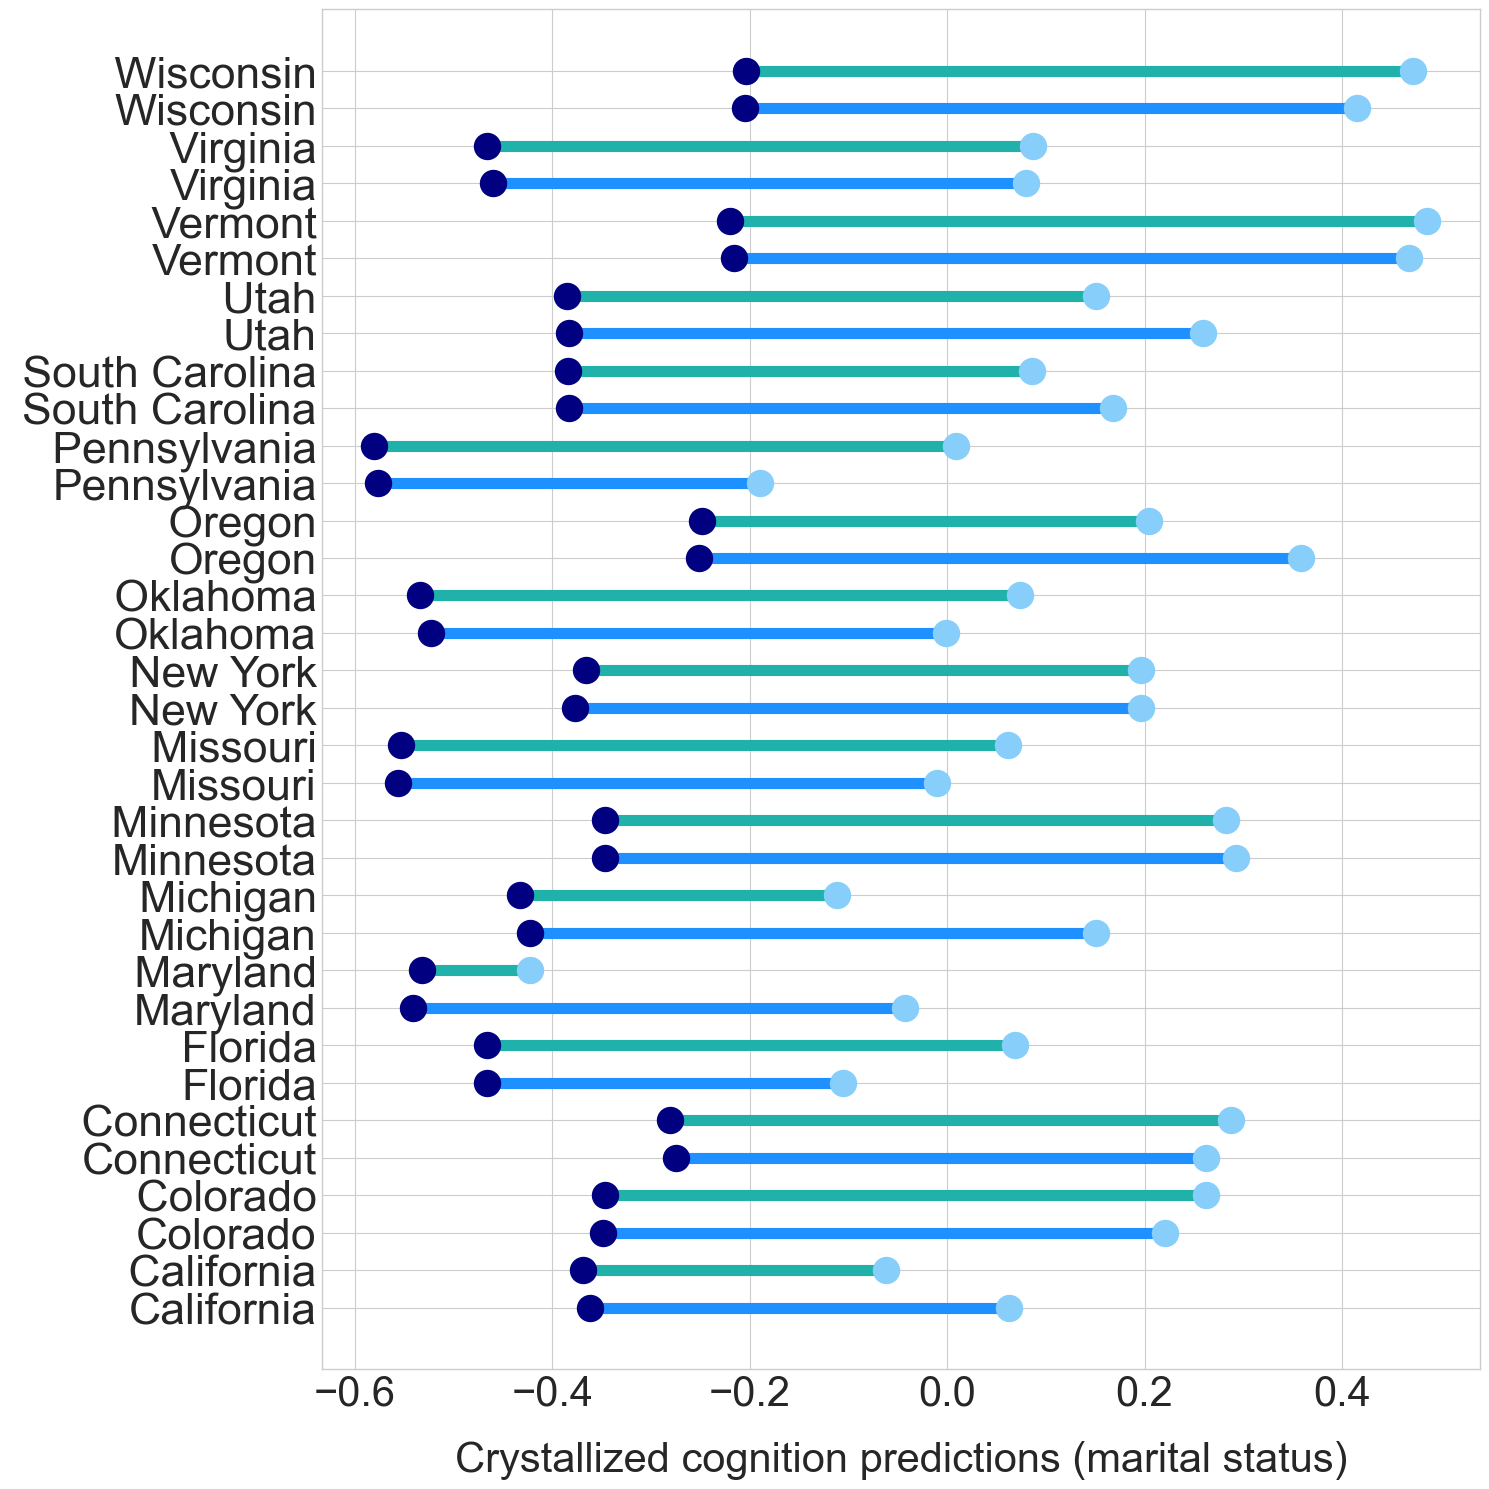

In [58]:
datas=mean_predictions_state
datas2=mean_predictions_state_ps
state_names = ['California',
 'Colorado',
 'Connecticut',
 'Florida',
 'Maryland',
 'Michigan',
 'Minnesota',
 'Missouri',
 'New York',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'South Carolina',
 'Utah',
 'Vermont',
 'Virginia',
 'Wisconsin']
state_names2 = [' California',
 ' Colorado',
 ' Connecticut',
 ' Florida',
 ' Maryland',
 ' Michigan',
 ' Minnesota',
 ' Missouri',
 ' New York',
 ' Oklahoma',
 ' Oregon',
 ' Pennsylvania',
 ' South Carolina',
 ' Utah',
 ' Vermont',
 ' Virginia',
 ' Wisconsin']
# Plotting
plt.figure(figsize=(15, 15))

# Transpose the data matrix to iterate over states
for state_name, state_values,state_name2, state_values2 in zip(state_names, np.array(datas).T,state_names2, np.array(datas2).T):
    plt.plot(state_values, [state_name, state_name], 'k-',color='dodgerblue', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
    plt.plot(state_values2, [state_name2, state_name2], 'k-',color='lightseagreen', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state
    
    plt.scatter(state_values[0], state_name, color='navy', label='sp HH', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(state_values[1], state_name, color='lightskyblue', label='tp HH', s=350,zorder=2)  # Plot value 2 for the state
    
    plt.scatter(state_values2[0], state_name2, color='navy', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(state_values2[1], state_name2, color='lightskyblue', s=350,zorder=2)  # Plot value 2 for the state
    
plt.xticks(size=30)
plt.yticks(size=32)
plt.xlabel('Crystallized cognition predictions (marital status)',size= 30,labelpad=20)
#plt.ylabel('States',size=25)
#plt.title('Values for Each State')
#plt.legend(['before PS','after PS','tp HH', 'sp HH'],loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.grid(True)
plt.tight_layout()
#plt.savefig('lolli_plot_marry_crystallized_ps_state_cognition_results_f5.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()


/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_43398/3906843063.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(race_values, [race_name, race_name], 'k-',color='dodgerblue', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_43398/3906843063.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(race_values2, [race_name2, race_name2], 'k-',color='lightseagreen', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state


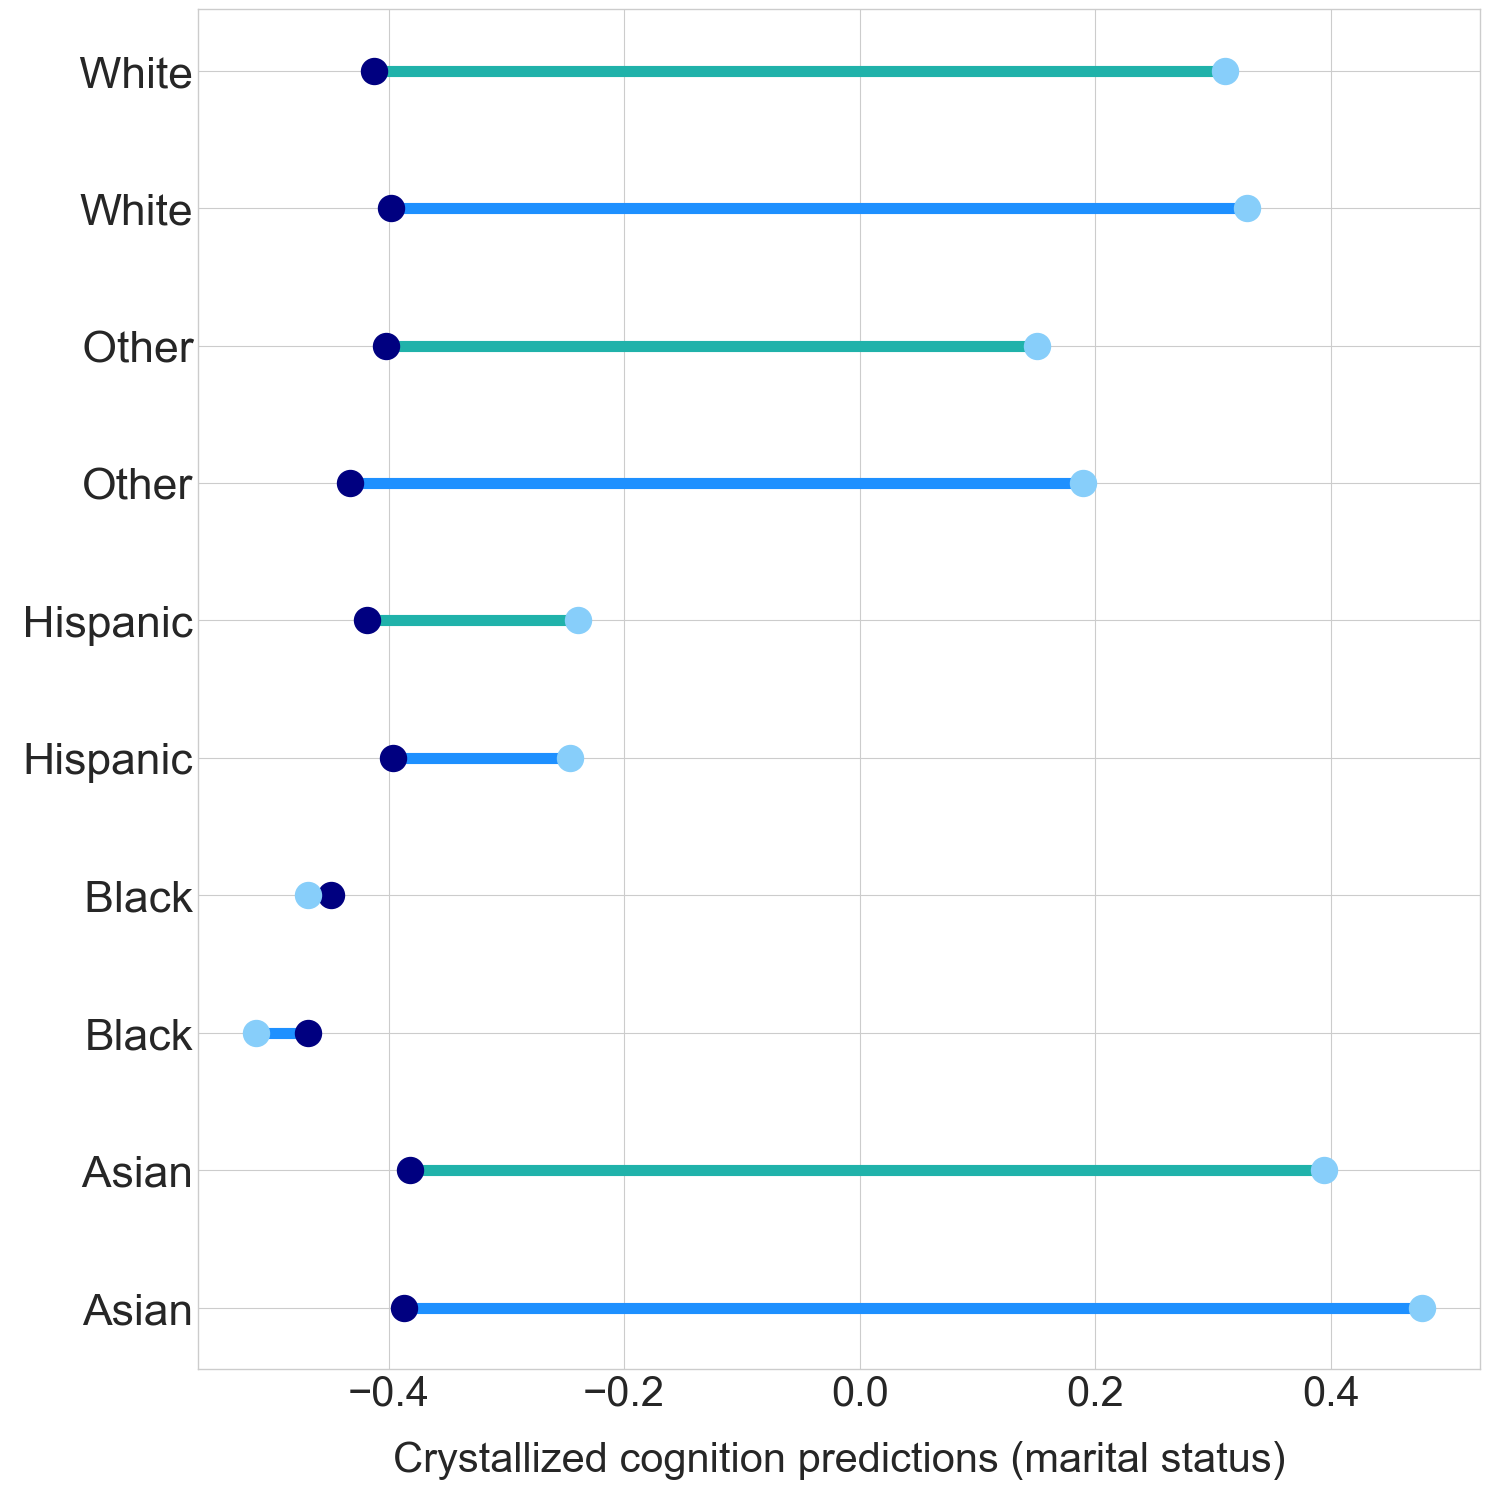

In [59]:
datas_r=mean_predictions_race
datas_r2=mean_predictions_race_ps
race_names = ['Asian',
 'Black',
 'Hispanic',
 'Other',
 'White']
#dont forget the blank space in front of the name so not overwritten
race_names2 = [' Asian',
 ' Black',
 ' Hispanic',
 ' Other',
 ' White']
# Plotting
plt.figure(figsize=(15, 15))

# Transpose the data matrix to iterate over states
for race_name, race_values,race_name2, race_values2 in zip(race_names, np.array(datas_r).T,race_names2, np.array(datas_r2).T):
    plt.plot(race_values, [race_name, race_name], 'k-',color='dodgerblue', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
    plt.plot(race_values2, [race_name2, race_name2], 'k-',color='lightseagreen', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state
    
    plt.scatter(race_values[0], race_name, color='navy', label='sp HH', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(race_values[1], race_name, color='lightskyblue', label='tp HH', s=350,zorder=2)  # Plot value 2 for the state
    
    plt.scatter(race_values2[0], race_name2, color='navy', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(race_values2[1], race_name2, color='lightskyblue', s=350,zorder=2)  # Plot value 2 for the state
    
plt.xticks(size=30)
plt.yticks(size=32)
plt.xlabel('Crystallized cognition predictions (marital status)',size= 30,labelpad=20)
#plt.ylabel('States',size=25)
#plt.title('Values for Each Race')
#plt.legend(['before PS','after PS','sp HH', 'tp HH'],loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.grid(True)
plt.tight_layout()
#plt.savefig('lolli_plot_marry_crystallized_ps_race_cognition_results_f5.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()